<a href="https://colab.research.google.com/github/abunchoftigers/Prediction-of-Product-Sales/blob/main/Prediction_of_Product_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Product Sales

- Author David Dyer

## Project Overview

By looking at past sales data we can look into the many possible futures.

## Set Up

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn import set_config
set_config(transform_output='pandas')

import warnings

warnings.simplefilter('ignore')

### Define regression metrics

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  # Get metrics
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    # Print Result with Label and Header
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,
                 'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
  
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,
                        output_frame=False):
  # Get predictions for training data
  y_train_pred = reg.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,
                                     output_dict=output_frame,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = reg.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,
                                  output_dict=output_frame,
                                    label='Test Data' )
  # Store results in a dataframe if ouput_frame is True
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    # Set the label as the index
    results_df = results_df.set_index('Label')
    # Set index.name to none to get a cleaner looking result
    results_df.index.name=None
    # Return the dataframe
    return results_df.round(3)

### Load and Inspect Data

In [3]:
fpath = './data/sales_predictions_2023.csv'
df = pd.read_csv(fpath)

In [4]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Data Cleaning

First let's learn some things about our data.

In [6]:
print(f'{df.shape[0]} rows\n{df.shape[1]} columns')

8523 rows
12 columns


In [7]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [8]:
df.duplicated().value_counts(), df.duplicated().sum() # Hooray no duplicates!

(False    8523
 dtype: int64,
 0)

In [9]:
pd.isna(df).sum() # Some weights and outlet sizes are missing

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

We'll replace missing string types with 'MISSING', and missing numeric types with -1.

### Check the dtype of every column

In [10]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [11]:
df.select_dtypes('object') # Placeholder 'MISSING' looks ok for Outlet_Size

,Item_Identifier,Item_Fat_Content,Item_Type,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDA15,Low Fat,Dairy,OUT049,Medium,Tier 1,Supermarket Type1
1,DRC01,Regular,Soft Drinks,OUT018,Medium,Tier 3,Supermarket Type2
2,FDN15,Low Fat,Meat,OUT049,Medium,Tier 1,Supermarket Type1
3,FDX07,Regular,Fruits and Vegetables,OUT010,NaN,Tier 3,Grocery Store
4,NCD19,Low Fat,Household,OUT013,High,Tier 3,Supermarket Type1
...,...,...,...,...,...,...,...
8518,FDF22,Low Fat,Snack Foods,OUT013,High,Tier 3,Supermarket Type1
8519,FDS36,Regular,Baking Goods,OUT045,NaN,Tier 2,Supermarket Type1
8520,NCJ29,Low Fat,Health and Hygiene,OUT035,Small,Tier 2,Supermarket Type1
8521,FDN46,Regular,Snack Foods,OUT018,Medium,Tier 3,Supermarket Type2


### Fill in missing string values

In [12]:
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].fillna(value='MISSING')


### Fill in missing numeric values

In [13]:
num_cols = df.select_dtypes(include='number').columns
df[num_cols] = df[num_cols].fillna(value=-1)

### Check for nulls

In [14]:
pd.isna(df).sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

### Find and fix inconsistent categories of data

In [15]:
string_cols = df.select_dtypes('object').columns
string_cols
line_break = "\n"

for col in string_cols:
  print(f'Value Counts for {col}: ')
  print(df[col].value_counts())
  print('\n')

Value Counts for Item_Identifier: 
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64


Value Counts for Item_Fat_Content: 
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64


Value Counts for Item_Type: 
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64


Value Counts for Outlet_Identifier: 
OUT027    935
OUT013    932
OUT049    930
OUT046

Item_Fat_Content can use some cleaning. First, we'll create a map of the inconsistently formatted values to the correctly formatted values.

In [16]:
item_fat_map = {
    'LF': 'Low Fat',
    'low fat': 'Low Fat',
    'reg': 'Regular'
}

The labels (high, medium, low) for Outlet_Size are confusing. Let's change them

In [17]:
outlet_size_map = {
  'Low': 'Small',
  'High': 'Large'
}

### Update dataframe with cleaned values

In [18]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace(item_fat_map)
df['Outlet_Size'] = df['Outlet_Size'].replace(outlet_size_map)

In [19]:
# Make sure it worked
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

In [20]:
# Make sure it worked
df['Outlet_Size'].value_counts()

Medium     2793
MISSING    2410
Small      2388
Large       932
Name: Outlet_Size, dtype: int64

## Exploratory Data Analysis

Let's take a look at some statistical summaries for each numeric column.

In [21]:
for col in df[num_cols]:
  print(f'{col:} {line_break} Lowest:  {df[col].min()}{line_break} Highest: {df[col].max()}{line_break} Mean:    {df[col].mean()}{line_break}')

Item_Weight 
 Lowest:  -1.0
 Highest: 21.35
 Mean:    10.478936407368296

Item_Visibility 
 Lowest:  0.0
 Highest: 0.328390948
 Mean:    0.06613202877895108

Item_MRP 
 Lowest:  31.29
 Highest: 266.8884
 Mean:    140.9927819781767

Outlet_Establishment_Year 
 Lowest:  1985
 Highest: 2009
 Mean:    1997.8318667135984

Item_Outlet_Sales 
 Lowest:  33.29
 Highest: 13086.9648
 Mean:    2181.288913575032



### Histograms for numeric data

In [22]:
num_cols

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

### Item_Weight

<Axes: xlabel='Item_Weight', ylabel='Count'>

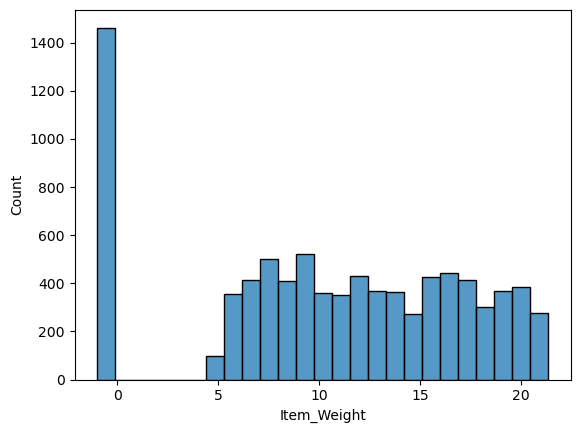

In [23]:
sns.histplot(data=df, x='Item_Weight')

### Item_Visibility

<Axes: xlabel='Item_Visibility', ylabel='Count'>

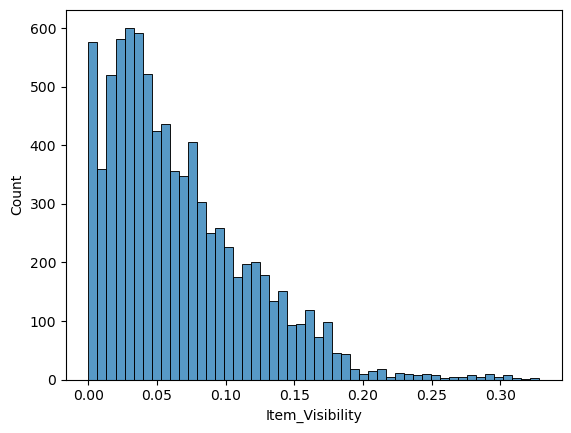

In [24]:
sns.histplot(data=df, x='Item_Visibility')

### Item_MRP

<Axes: xlabel='Item_MRP', ylabel='Count'>

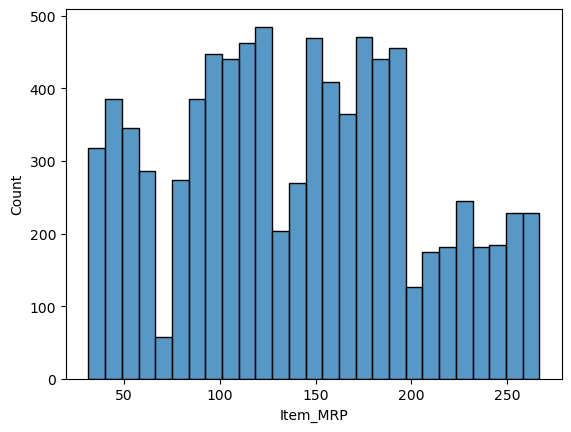

In [25]:
sns.histplot(data=df, x='Item_MRP')

### Outlet_Establishment_Year

<Axes: xlabel='Outlet_Establishment_Year', ylabel='Count'>

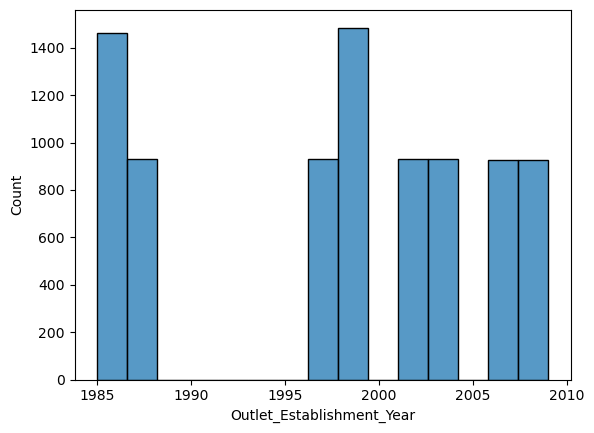

In [26]:
sns.histplot(data=df, x='Outlet_Establishment_Year')

### Item_Outlet_Sales

<Axes: xlabel='Item_Outlet_Sales', ylabel='Count'>

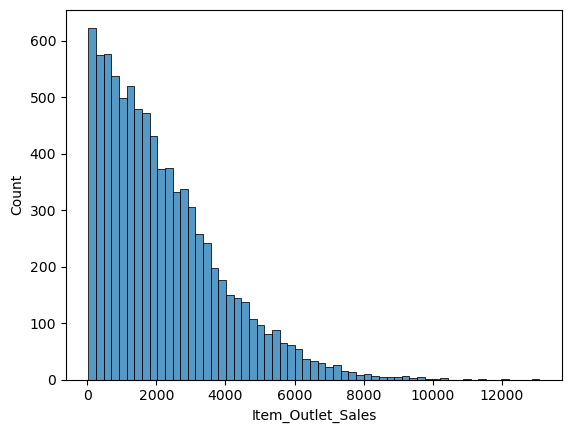

In [27]:
sns.histplot(data=df, x='Item_Outlet_Sales')

### Boxplots: View statistical summaries of numerical features

In [28]:
df.set_index('Item_Identifier')

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
Item_Identifier,,,,,,,,,,,
FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,MISSING,Tier 3,Grocery Store,732.3800
NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,Large,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...
FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,Large,Tier 3,Supermarket Type1,2778.3834
FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,MISSING,Tier 2,Supermarket Type1,549.2850
NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136


#### Item_Weight


sns.boxplot(data=df, x='Item_Weight')

<Axes: xlabel='Item_Weight'>

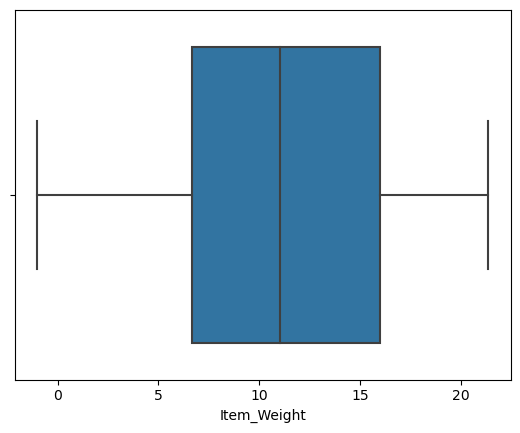

In [29]:
sns.boxplot(data=df, x='Item_Weight')

#### Item_Visibility

<Axes: xlabel='Item_Visibility'>

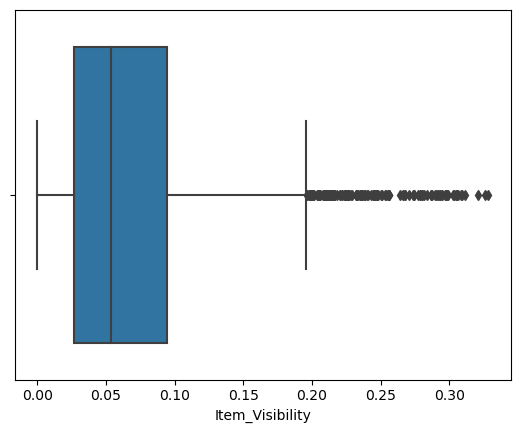

In [30]:
sns.boxplot(data=df, x='Item_Visibility')

#### Item_MRP

<Axes: xlabel='Item_MRP'>

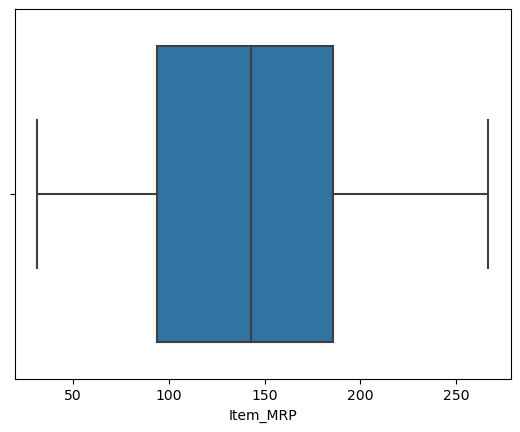

In [31]:
sns.boxplot(data=df, x='Item_MRP')

#### Outlet_Establishment_Year

<Axes: xlabel='Outlet_Establishment_Year'>

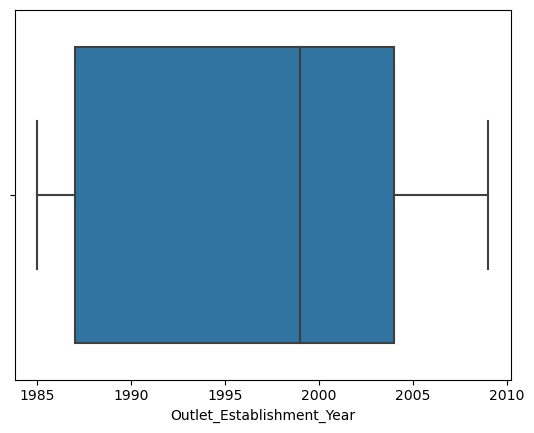

In [32]:
sns.boxplot(data=df, x='Outlet_Establishment_Year')

#### Item_Outlet_Sales

<Axes: xlabel='Item_Outlet_Sales'>

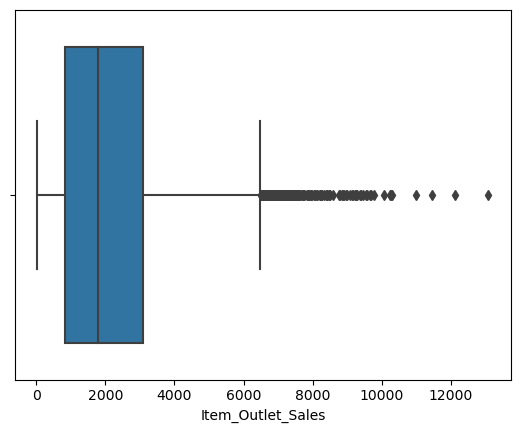

In [33]:
sns.boxplot(data=df, x='Item_Outlet_Sales')

### Countplots: Frequencies of Catagorical Features

#### Item_Fat_Content

<Axes: xlabel='Item_Fat_Content', ylabel='count'>

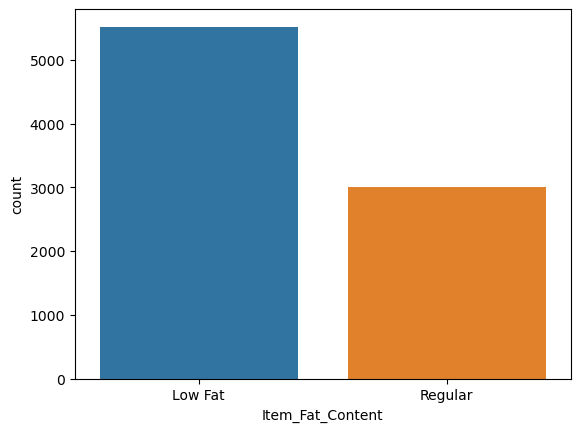

In [34]:
sns.countplot(data=df, x='Item_Fat_Content')

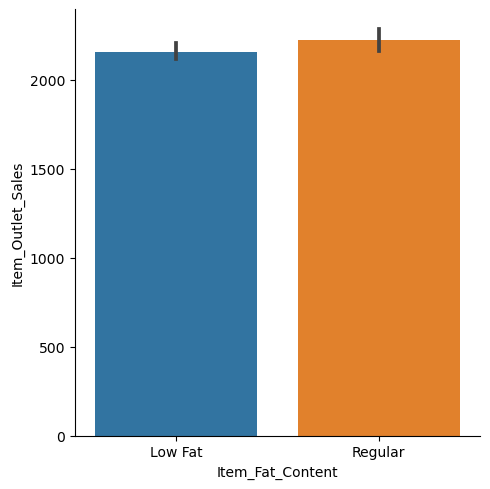

In [35]:
# Plot Item_Fat_Content vs Item_Outlet_Sales
sns.catplot(data=df, x='Item_Fat_Content', y='Item_Outlet_Sales', kind='bar')


#### Item_Type

In [36]:
df.sort_values('Item_Outlet_Sales')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
906,DRK12,9.500,Low Fat,0.000000,Soft Drinks,32.8900,OUT010,1998,MISSING,Tier 3,Grocery Store,33.2900
6950,NCR42,9.105,Low Fat,0.064411,Household,33.3900,OUT010,1998,MISSING,Tier 3,Grocery Store,33.2900
2571,FDU21,-1.000,Regular,0.134328,Snack Foods,35.0558,OUT019,1985,Small,Tier 1,Grocery Store,33.9558
3053,NCL41,-1.000,Low Fat,0.073077,Health and Hygiene,34.3216,OUT019,1985,Small,Tier 1,Grocery Store,34.6216
7388,FDQ47,7.155,Regular,0.281510,Breads,33.8874,OUT010,1998,MISSING,Tier 3,Grocery Store,35.2874
...,...,...,...,...,...,...,...,...,...,...,...,...
6541,FDI50,-1.000,Regular,0.030693,Canned,228.0352,OUT027,1985,Medium,Tier 3,Supermarket Type3,10306.5840
4349,FDP33,-1.000,Low Fat,0.088840,Snack Foods,254.2672,OUT027,1985,Medium,Tier 3,Supermarket Type3,10993.6896
1450,FDZ20,-1.000,Low Fat,0.000000,Fruits and Vegetables,253.0356,OUT027,1985,Medium,Tier 3,Supermarket Type3,11445.1020
5223,FDQ19,-1.000,Regular,0.014296,Fruits and Vegetables,242.6512,OUT027,1985,Medium,Tier 3,Supermarket Type3,12117.5600


In [37]:
# df.sort_values('Item_Outlet_Sales', ascending=False)["Item_Type"]

df_agg = df.groupby(['Item_Type'])['Item_Outlet_Sales'].mean().reset_index().sort_values('Item_Outlet_Sales', ascending=False)

print(df_agg)

                Item_Type  Item_Outlet_Sales
15          Starchy Foods        2374.332773
12                Seafood        2326.065928
6   Fruits and Vegetables        2289.009592
13            Snack Foods        2277.321739
9               Household        2258.784300
4                   Dairy        2232.542597
3                  Canned        2225.194904
1                  Breads        2204.132226
10                   Meat        2158.977911
7             Hard Drinks        2139.221622
5            Frozen Foods        2132.867744
2               Breakfast        2111.808651
8      Health and Hygiene        2010.000265
14            Soft Drinks        2006.511735
0            Baking Goods        1952.971207
11                 Others        1926.139702


(1000.0, 3000.0)

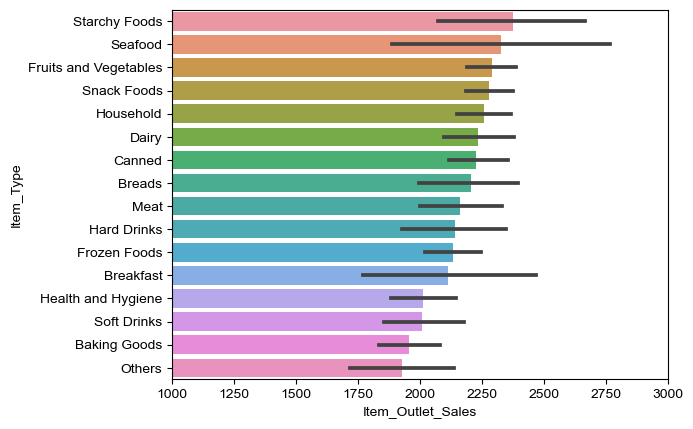

In [38]:
ax = sns.barplot(data=df, x='Item_Outlet_Sales', y='Item_Type', order=df_agg['Item_Type'])
sns.set_theme(rc={'figure.figsize':(12, 5)})
ax.set_xlim(1000, 3000)

#### Outlet_Identifier

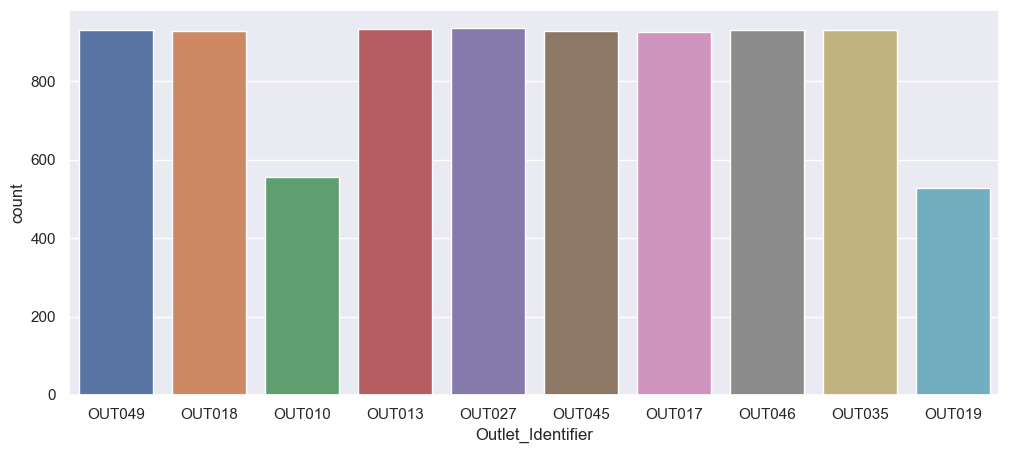

In [39]:
sns.countplot(data=df, x='Outlet_Identifier')
sns.set_theme(rc={'figure.figsize':(12, 4)})

#### Outlet_Size

<Axes: xlabel='Outlet_Size', ylabel='count'>

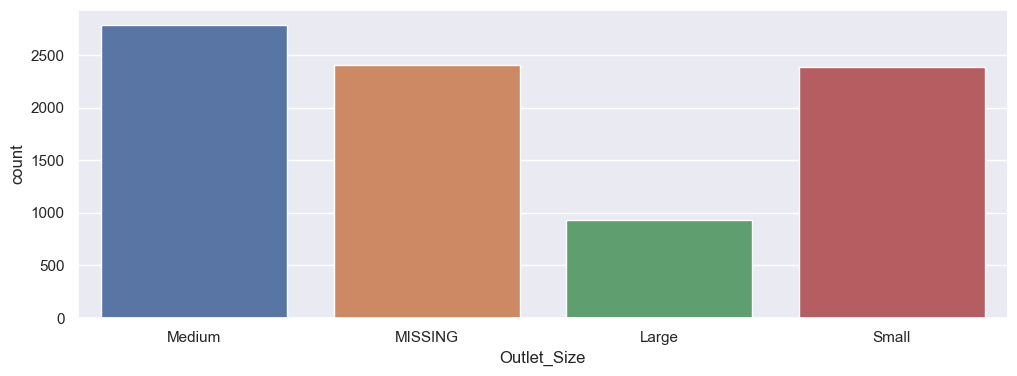

In [40]:
sns.countplot(data=df, x='Outlet_Size')

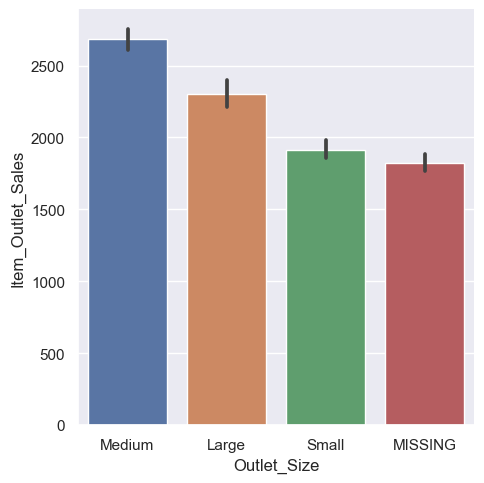

In [41]:
# Plot Outlet_Size vs Item_Outlet_Sales
sns.catplot(data=df, x='Outlet_Size', y='Item_Outlet_Sales', kind='bar', order=df.groupby('Outlet_Size')['Item_Outlet_Sales'].mean().sort_values(ascending=False).index)

#### Outlet_Location_Type

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

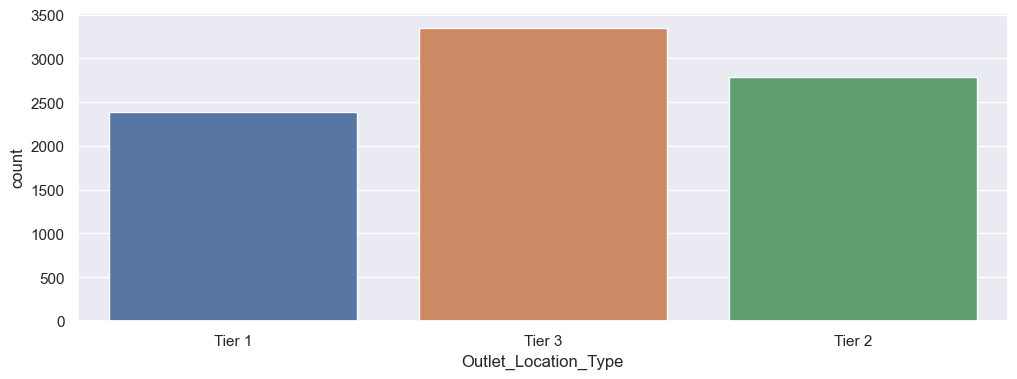

In [42]:
sns.countplot(data=df, x='Outlet_Location_Type')

#### Outlet_Type

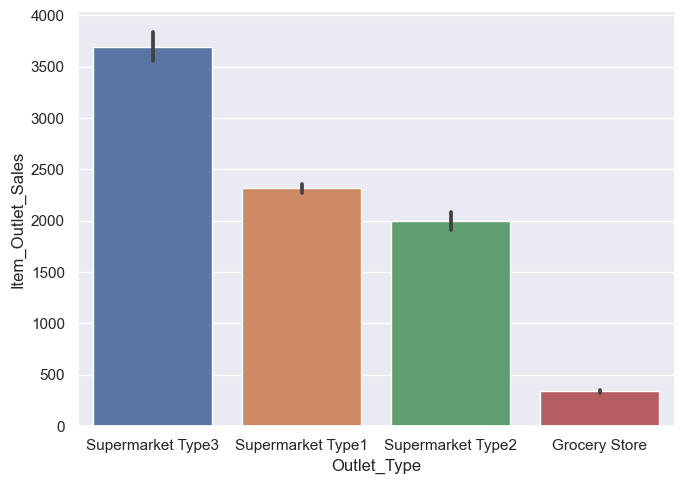

In [44]:
sns.catplot(data=df, x='Outlet_Type', y='Item_Outlet_Sales', kind='bar', aspect=1.4, order=df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False).index)

In [45]:
obj_cols

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

### Heatmap: Correlations

<Axes: >

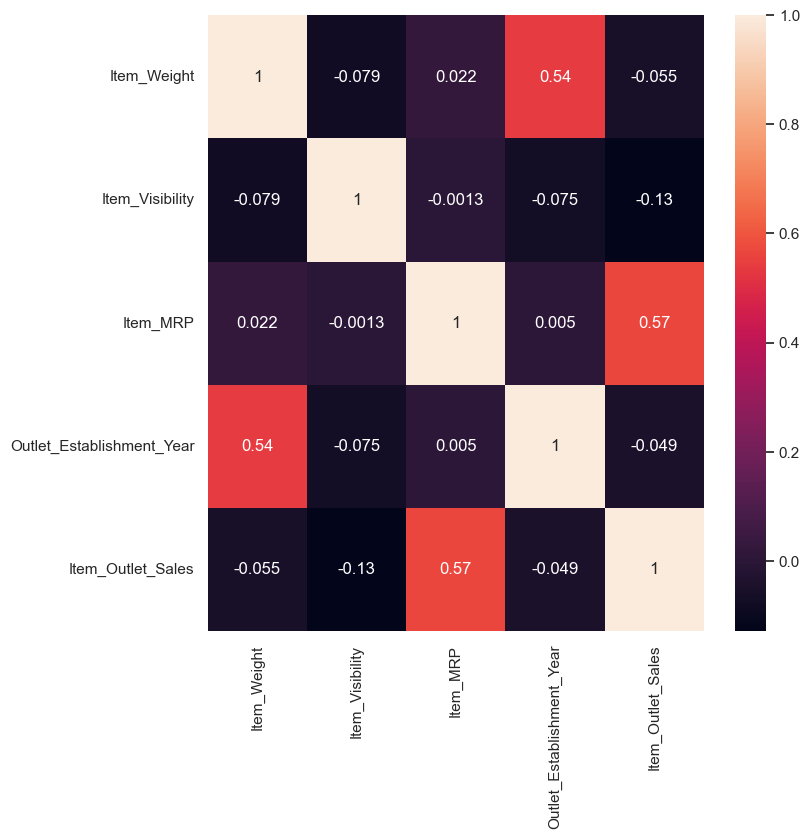

In [46]:
corr = df.corr()
sns.heatmap(corr, annot=True)

## Feature Inspection

In [47]:
# First, let's replace the placeholders we added with nulls
df[obj_cols] = df[obj_cols].replace('MISSING', None)
df[obj_cols]

df[num_cols] = df[num_cols].replace(-1, None)
df[num_cols]

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
0,9.3,0.016047,249.8092,1999,3735.1380
1,5.92,0.019278,48.2692,2009,443.4228
2,17.5,0.016760,141.6180,1999,2097.2700
3,19.2,0.000000,182.0950,1998,732.3800
4,8.93,0.000000,53.8614,1987,994.7052
...,...,...,...,...,...
8518,6.865,0.056783,214.5218,1987,2778.3834
8519,8.38,0.046982,108.1570,2002,549.2850
8520,10.6,0.035186,85.1224,2004,1193.1136
8521,7.21,0.145221,103.1332,2009,1845.5976


In [48]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [49]:
def get_next_column():
  n = 0;
  cols = list(df.columns)
  while n < len(cols):
    yield df[cols[n]]
    n = (n+1) % len(cols)

In [50]:
def eda_answers(f, data={}):
  fdata = {
  'name' : f.name,
  'dtype' : f.dtype,
  'nulls' : f.isna().value_counts(),
  'constant' : f.nunique() == 1,
  'quasi_constant' : f.value_counts().filter(items = f.mode()) / len(f) >= .98,
  'cardinality' : f.nunique(),
  'high_cardinality' : f.nunique() > 10,
  'known_before' : "",
  'business_reason_to_exclude' : ""
  }
  fdata.update(data)

  [print(f'{key}: {val}') for key,val in fdata.items()]

### Item_Identifier
Product ID

In [51]:
f_gen = get_next_column()

eda_answers(next(f_gen), {"business_reason_to_exclude": "This is a unique identifier"})

name: Item_Identifier
dtype: object
nulls: False    8523
Name: Item_Identifier, dtype: int64
constant: False
quasi_constant: FDG33    False
FDW13    False
Name: Item_Identifier, dtype: bool
cardinality: 1559
high_cardinality: True
known_before: 
business_reason_to_exclude: This is a unique identifier


### Item_Weight

Weight of product

In [52]:
eda_answers(next(f_gen))

name: Item_Weight
dtype: object
nulls: False    7060
True     1463
Name: Item_Weight, dtype: int64
constant: False
quasi_constant: 12.15    False
Name: Item_Weight, dtype: bool
cardinality: 415
high_cardinality: True
known_before: 
business_reason_to_exclude: 



### Item_Fat_Content

Whether the product is low-fat or regular

In [53]:
eda_answers(next(f_gen))

name: Item_Fat_Content
dtype: object
nulls: False    8523
Name: Item_Fat_Content, dtype: int64
constant: False
quasi_constant: Low Fat    False
Name: Item_Fat_Content, dtype: bool
cardinality: 2
high_cardinality: False
known_before: 
business_reason_to_exclude: 


### Item_Visibility

The percentage of total display area of all products in a store allocated to the particular product

In [54]:
eda_answers(next(f_gen))

name: Item_Visibility
dtype: float64
nulls: False    8523
Name: Item_Visibility, dtype: int64
constant: False
quasi_constant: 0.0    False
Name: Item_Visibility, dtype: bool
cardinality: 7880
high_cardinality: True
known_before: 
business_reason_to_exclude: 


### Item_Type

The category to which the product belongs

In [55]:
eda_answers(next(f_gen))

name: Item_Type
dtype: object
nulls: False    8523
Name: Item_Type, dtype: int64
constant: False
quasi_constant: Fruits and Vegetables    False
Name: Item_Type, dtype: bool
cardinality: 16
high_cardinality: True
known_before: 
business_reason_to_exclude: 


### Item_MRP

Maximum Retail Price (list price) of the product


In [56]:
eda_answers(next(f_gen))

name: Item_MRP
dtype: float64
nulls: False    8523
Name: Item_MRP, dtype: int64
constant: False
quasi_constant: 172.0422    False
Name: Item_MRP, dtype: bool
cardinality: 5938
high_cardinality: True
known_before: 
business_reason_to_exclude: 


### Outlet_Identifier

Store ID

In [57]:
eda_answers(next(f_gen))

name: Outlet_Identifier
dtype: object
nulls: False    8523
Name: Outlet_Identifier, dtype: int64
constant: False
quasi_constant: OUT027    False
Name: Outlet_Identifier, dtype: bool
cardinality: 10
high_cardinality: False
known_before: 
business_reason_to_exclude: 



### Outlet_Establishment_Year

The year in which store was established

In [58]:
eda_answers(next(f_gen))

name: Outlet_Establishment_Year
dtype: int64
nulls: False    8523
Name: Outlet_Establishment_Year, dtype: int64
constant: False
quasi_constant: 1985    False
Name: Outlet_Establishment_Year, dtype: bool
cardinality: 9
high_cardinality: False
known_before: 
business_reason_to_exclude: 


### Outlet_Size

The size of the store in terms of ground area covered

In [59]:
eda_answers(next(f_gen))

name: Outlet_Size
dtype: object
nulls: False    6113
True     2410
Name: Outlet_Size, dtype: int64
constant: False
quasi_constant: Medium    False
Name: Outlet_Size, dtype: bool
cardinality: 3
high_cardinality: False
known_before: 
business_reason_to_exclude: 


### Outlet_Location_Type

The type of area in which the store is located

In [60]:
eda_answers(next(f_gen))

name: Outlet_Location_Type
dtype: object
nulls: False    8523
Name: Outlet_Location_Type, dtype: int64
constant: False
quasi_constant: Tier 3    False
Name: Outlet_Location_Type, dtype: bool
cardinality: 3
high_cardinality: False
known_before: 
business_reason_to_exclude: 


### Outlet_Type

Whether the outlet is a grocery store or some sort of supermarket

In [61]:
eda_answers(next(f_gen))

name: Outlet_Type
dtype: object
nulls: False    8523
Name: Outlet_Type, dtype: int64
constant: False
quasi_constant: Supermarket Type1    False
Name: Outlet_Type, dtype: bool
cardinality: 4
high_cardinality: False
known_before: 
business_reason_to_exclude: 


In [62]:
df["Outlet_Type"].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64


### Item_Outlet_Sales

Sales of the product in the particular store. This is the target variable to be predicted.

In [63]:
eda_answers(next(f_gen))

name: Item_Outlet_Sales
dtype: float64
nulls: False    8523
Name: Item_Outlet_Sales, dtype: int64
constant: False
quasi_constant: 958.752    False
Name: Item_Outlet_Sales, dtype: bool
cardinality: 3493
high_cardinality: True
known_before: 
business_reason_to_exclude: 
